# SELF-SUPERVISED DENOISING: PART TWO
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

On completion of this tutorial you will have learnt how to adapt your previously wrote blind-spot denoising procedure to handle noise that has some temporal relationship. In this instance, we imitate this using bandpassed noise. At the end of the tutorial, you will have the opportunity to denoise a field dataset often used for benchmarking random noise suppression procedures.


### Recap
As a reminder, the networks are trained in a self-supervised manner, i.e., the training data is the same as the inference data with no labels required! This tutorial is the second in the second in our self-supervised denoising series. For a recap on the methodology and the denoising performance under idealistic scenarios, review Tutorial One.

***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Our unet functions just to speed things up
from unet import UNet
from tutorial_utils import regular_patching_2D, add_whitegaussian_noise

In [2]:
cmap='RdBu'
vmin = -0.5
vmax = 0.5

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the data folder of the repository: https://github.com/swag-kaust/Transform2022_SelfSupervisedDenoising

In [3]:
d = np.load("/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/data/Hess_poststack.npy")
d /= np.max(abs(d))
print(d.shape)

(198, 453)


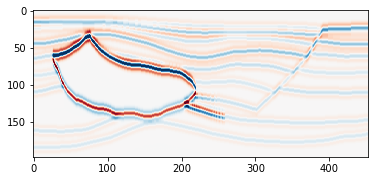

In [4]:
# Plot to see the noise free data
plt.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

In [5]:
noisydata, _ = add_whitegaussian_noise(d, sc=0.1)

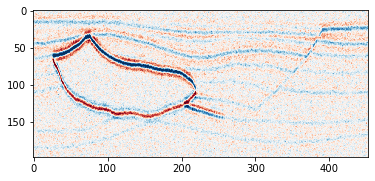

In [6]:
# plot to see the noisy data
plt.imshow(noisydata, cmap=cmap, vmin=vmin, vmax=vmax)

### Patch data

In [24]:
noisy_patches = regular_patching_2D(noisydata, 
                                    patchsize=[32, 32], 
                                    step=[8,8])

Extracting 1113 patches


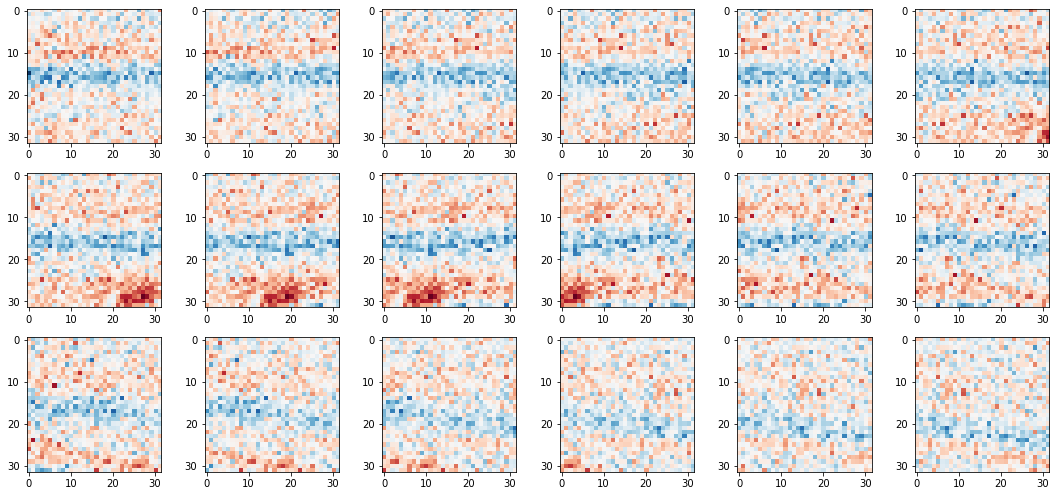

In [25]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

In [9]:
# Create a function that randomly selects and corrupts pixels following N2V methodology
def multi_active_pixels(patch, 
                        num_activepixels, 
                        neighbourhood_radius=5, 
                        swap=True):

    n_rad = neighbourhood_radius  # descriptive variable name too long

    # Select multiple locations for active pixels
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)

    # For each active pixel compute shift for finding neighbouring pixel and find pixel
    x_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    y_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    
    # OPTIONAL: don't allow replacement with itself
    for i in range(len(x_neigh_shft)):
        if x_neigh_shft[i] == 0 and y_neigh_shft[i] == 0:
            # This means its replacing itself with itself...not good!
            shft_options = np.trim_zeros(np.arange(-n_rad // 2 + 1, n_rad // 2 + 1))
            x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)

    # Find x and y locations of neighbours for the replacement
    idx_neigh = idx_aps + x_neigh_shft
    idy_neigh = idy_aps + y_neigh_shft

    # Make sure neighbouring pixels within window
    idx_neigh = idx_neigh + (idx_neigh < 0) * patch.shape[0] - (idx_neigh >= patch.shape[0]) * patch.shape[0]
    idy_neigh = idy_neigh + (idy_neigh < 0) * patch.shape[1] - (idy_neigh >= patch.shape[1]) * patch.shape[1]
    
    # combine x and y coordinates for active pixels and neighbouring pixels
    id_aps = (idx_aps, idy_aps)
    id_neigh = (idx_neigh, idy_neigh)
    
    # Make mask and corrupted patch
    mask = np.ones_like(patch)
    cp_ptch = patch.copy()
    mask[id_aps] = 0.
    if swap:
        cp_ptch[id_aps] = patch[id_neigh]
    else:
        cp_ptch[id_aps] = 0

    return cp_ptch, mask


In [10]:
# Check the corruption function works
crpt_patch, mask = multi_active_pixels(noisy_patches[0], 
                                  num_activepixels=50, 
                                  neighbourhood_radius=5, 
                                  swap=True)

Text(0.5, 1.0, 'Corruption Mask')

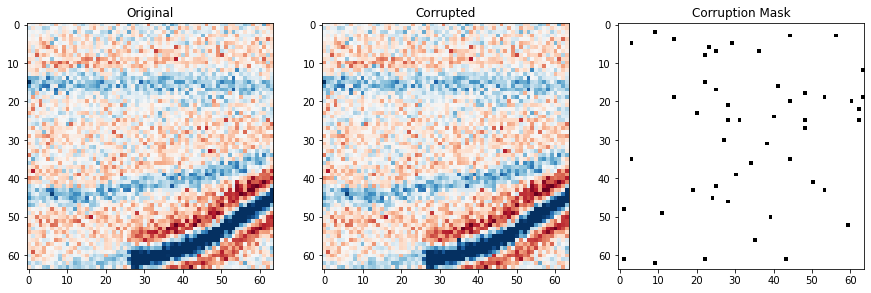

In [11]:
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(noisy_patches[0], cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(crpt_patch, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(mask, cmap='binary_r')

axs[0].set_title('Original')
axs[1].set_title('Corrupted')
axs[2].set_title('Corruption Mask')

***

# Step three - Set up network

In [12]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


In [13]:
# Build UNet
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)


In [14]:
# Network initialisation steps
n_epochs = 200
lr = 0.0001
criterion = nn.MSELoss()
optim = torch.optim.Adam(network.parameters(), lr=lr)

In [15]:
# Data training parameters
n_training = 700

perc_active = 5
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
num_activepixels = np.floor((total_num_pixels/100) * perc_active)
print(num_activepixels)

204.0


***

# Step four - training

In [16]:
# Initial train and val 
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
val_loss_history = np.zeros(n_epochs)
val_accuracy_history = np.zeros(n_epochs)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

In [17]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    
    model.train()
    accuracy = 0
    loss = 0

    for dl in tqdm(data_loader):
        X, y, mask = dl[0], dl[1], dl[2]
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()

        yprob = model(X)

        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        ls.backward()
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        loss += ls.item()
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))
        
    loss /= len(data_loader)
    accuracy /= len(data_loader)   

    return loss, accuracy

In [18]:
# TRAINING
for ep in range(n_epochs):  
    
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=5, 
                                                               swap=True
                                                              )

    # MAKE DATA LOADERS
    # Remember to add 1 to 2nd dim - Pytorch is [#data, #channels, height, width]
    # Define Train Set
    train_X = np.expand_dims(corrupted_patches[:n_training],axis=1)
    train_y = np.expand_dims(noisy_patches[:n_training],axis=1)    
    msk = np.expand_dims(masks[:n_training],axis=1)    
    X_train = torch.from_numpy(train_X).float()
    y_train = torch.from_numpy(train_y).float()
    train_dataset = TensorDataset(X_train, 
                                  y_train, 
                                  torch.from_numpy(msk).float(),)

    # Define Test Set
    test_X = np.expand_dims(corrupted_patches[n_training:],axis=1)
    test_y = np.expand_dims(noisy_patches[n_training:],axis=1)
    msk = np.expand_dims(masks[n_training:],axis=1) 
    X_test = torch.from_numpy(test_X).float()
    y_test = torch.from_numpy(test_y).float()
    test_dataset = TensorDataset(X_test, 
                                 y_test, 
                                 torch.from_numpy(msk).float(),)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # TRAIN
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)

#     test_loss, test_accuracy, test_metrics = n2v_evaluate(network, 
#                                                            criterion,
#                                                            test_loader, 
#                                                            device,
#                                                             synth=False,
#                                                             plotflag=True if ep%5==0 else False)

    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy
#     test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, ''')
#     Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|██████████| 6/6 [00:01<00:00,  4.14it/s]


Epoch 0, 
    Training Loss 0.0109,     Training Accuracy 0.4587, 


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


Epoch 1, 
    Training Loss 0.0028,     Training Accuracy 0.2379, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 2, 
    Training Loss 0.0014,     Training Accuracy 0.1681, 


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


Epoch 3, 
    Training Loss 0.0010,     Training Accuracy 0.1412, 


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Epoch 4, 
    Training Loss 0.0008,     Training Accuracy 0.1305, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 5, 
    Training Loss 0.0008,     Training Accuracy 0.1262, 


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


Epoch 6, 
    Training Loss 0.0007,     Training Accuracy 0.1198, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 7, 
    Training Loss 0.0007,     Training Accuracy 0.1166, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 8, 
    Training Loss 0.0007,     Training Accuracy 0.1144, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 9, 
    Training Loss 0.0007,     Training Accuracy 0.1146, 


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Epoch 10, 
    Training Loss 0.0006,     Training Accuracy 0.1124, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 11, 
    Training Loss 0.0006,     Training Accuracy 0.1111, 


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Epoch 12, 
    Training Loss 0.0006,     Training Accuracy 0.1099, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 13, 
    Training Loss 0.0006,     Training Accuracy 0.1104, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 14, 
    Training Loss 0.0006,     Training Accuracy 0.1093, 


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Epoch 15, 
    Training Loss 0.0006,     Training Accuracy 0.1084, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 16, 
    Training Loss 0.0006,     Training Accuracy 0.1080, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 17, 
    Training Loss 0.0006,     Training Accuracy 0.1078, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 18, 
    Training Loss 0.0006,     Training Accuracy 0.1076, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 19, 
    Training Loss 0.0006,     Training Accuracy 0.1084, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 20, 
    Training Loss 0.0006,     Training Accuracy 0.1079, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 21, 
    Training Loss 0.0006,     Training Accuracy 0.1071, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 22, 
    Training Loss 0.0006,     Training Accuracy 0.1068, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 23, 
    Training Loss 0.0006,     Training Accuracy 0.1072, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 24, 
    Training Loss 0.0006,     Training Accuracy 0.1067, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 25, 
    Training Loss 0.0006,     Training Accuracy 0.1066, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 26, 
    Training Loss 0.0006,     Training Accuracy 0.1065, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 27, 
    Training Loss 0.0006,     Training Accuracy 0.1066, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 28, 
    Training Loss 0.0006,     Training Accuracy 0.1062, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 29, 
    Training Loss 0.0006,     Training Accuracy 0.1064, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 30, 
    Training Loss 0.0006,     Training Accuracy 0.1060, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 31, 
    Training Loss 0.0006,     Training Accuracy 0.1059, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 32, 
    Training Loss 0.0006,     Training Accuracy 0.1059, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 33, 
    Training Loss 0.0006,     Training Accuracy 0.1059, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 34, 
    Training Loss 0.0006,     Training Accuracy 0.1060, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 35, 
    Training Loss 0.0006,     Training Accuracy 0.1062, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 36, 
    Training Loss 0.0006,     Training Accuracy 0.1054, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 37, 
    Training Loss 0.0006,     Training Accuracy 0.1064, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 38, 
    Training Loss 0.0006,     Training Accuracy 0.1060, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 39, 
    Training Loss 0.0006,     Training Accuracy 0.1054, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 40, 
    Training Loss 0.0006,     Training Accuracy 0.1052, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 41, 
    Training Loss 0.0006,     Training Accuracy 0.1056, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 42, 
    Training Loss 0.0006,     Training Accuracy 0.1055, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 43, 
    Training Loss 0.0006,     Training Accuracy 0.1055, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 44, 
    Training Loss 0.0006,     Training Accuracy 0.1054, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 45, 
    Training Loss 0.0006,     Training Accuracy 0.1053, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 46, 
    Training Loss 0.0006,     Training Accuracy 0.1056, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 47, 
    Training Loss 0.0006,     Training Accuracy 0.1054, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 48, 
    Training Loss 0.0005,     Training Accuracy 0.1051, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 49, 
    Training Loss 0.0006,     Training Accuracy 0.1054, 


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Epoch 50, 
    Training Loss 0.0006,     Training Accuracy 0.1053, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 51, 
    Training Loss 0.0006,     Training Accuracy 0.1053, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 52, 
    Training Loss 0.0005,     Training Accuracy 0.1052, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 53, 
    Training Loss 0.0006,     Training Accuracy 0.1052, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 54, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 55, 
    Training Loss 0.0006,     Training Accuracy 0.1054, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 56, 
    Training Loss 0.0006,     Training Accuracy 0.1057, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 57, 
    Training Loss 0.0005,     Training Accuracy 0.1052, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 58, 
    Training Loss 0.0006,     Training Accuracy 0.1057, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 59, 
    Training Loss 0.0005,     Training Accuracy 0.1055, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 60, 
    Training Loss 0.0005,     Training Accuracy 0.1055, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 61, 
    Training Loss 0.0006,     Training Accuracy 0.1061, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 62, 
    Training Loss 0.0006,     Training Accuracy 0.1059, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 63, 
    Training Loss 0.0006,     Training Accuracy 0.1054, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 64, 
    Training Loss 0.0005,     Training Accuracy 0.1053, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 65, 
    Training Loss 0.0005,     Training Accuracy 0.1052, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 66, 
    Training Loss 0.0006,     Training Accuracy 0.1053, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 67, 
    Training Loss 0.0006,     Training Accuracy 0.1053, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 68, 
    Training Loss 0.0005,     Training Accuracy 0.1049, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 69, 
    Training Loss 0.0005,     Training Accuracy 0.1049, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 70, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 71, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 72, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 73, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Epoch 74, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 75, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 76, 
    Training Loss 0.0005,     Training Accuracy 0.1051, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 77, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 78, 
    Training Loss 0.0005,     Training Accuracy 0.1047, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 79, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 80, 
    Training Loss 0.0005,     Training Accuracy 0.1047, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 81, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 82, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 83, 
    Training Loss 0.0005,     Training Accuracy 0.1047, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 84, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 85, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 86, 
    Training Loss 0.0005,     Training Accuracy 0.1051, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 87, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 88, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 89, 
    Training Loss 0.0005,     Training Accuracy 0.1047, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 90, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 91, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 92, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 93, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 94, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 95, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 96, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 97, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 98, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 99, 
    Training Loss 0.0005,     Training Accuracy 0.1047, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 100, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 101, 
    Training Loss 0.0005,     Training Accuracy 0.1052, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 102, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 103, 
    Training Loss 0.0005,     Training Accuracy 0.1052, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 104, 
    Training Loss 0.0005,     Training Accuracy 0.1049, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 105, 
    Training Loss 0.0005,     Training Accuracy 0.1047, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 106, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Epoch 107, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 108, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 109, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 110, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 111, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 112, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Epoch 113, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 114, 
    Training Loss 0.0005,     Training Accuracy 0.1043, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 115, 
    Training Loss 0.0005,     Training Accuracy 0.1043, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 116, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 117, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 118, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 119, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 120, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 121, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 122, 
    Training Loss 0.0005,     Training Accuracy 0.1048, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 123, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 124, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 125, 
    Training Loss 0.0005,     Training Accuracy 0.1043, 


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Epoch 126, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 127, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 128, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 129, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 130, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 131, 
    Training Loss 0.0005,     Training Accuracy 0.1042, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 132, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 133, 
    Training Loss 0.0005,     Training Accuracy 0.1043, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 134, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 135, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 136, 
    Training Loss 0.0005,     Training Accuracy 0.1042, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 137, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 138, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 139, 
    Training Loss 0.0005,     Training Accuracy 0.1043, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 140, 
    Training Loss 0.0005,     Training Accuracy 0.1043, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 141, 
    Training Loss 0.0005,     Training Accuracy 0.1043, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 142, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 143, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 144, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 145, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 146, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 147, 
    Training Loss 0.0005,     Training Accuracy 0.1045, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 148, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Epoch 149, 
    Training Loss 0.0005,     Training Accuracy 0.1049, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 150, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 151, 
    Training Loss 0.0005,     Training Accuracy 0.1054, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 152, 
    Training Loss 0.0005,     Training Accuracy 0.1053, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 153, 
    Training Loss 0.0005,     Training Accuracy 0.1046, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 154, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Epoch 155, 
    Training Loss 0.0005,     Training Accuracy 0.1047, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 156, 
    Training Loss 0.0005,     Training Accuracy 0.1049, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 157, 
    Training Loss 0.0005,     Training Accuracy 0.1050, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 158, 
    Training Loss 0.0005,     Training Accuracy 0.1044, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 159, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 160, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 161, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 162, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 163, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 164, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 165, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 166, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 167, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 168, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 169, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 170, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 171, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 172, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 173, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 174, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 175, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Epoch 176, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 177, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 178, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 179, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 180, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 181, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 182, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 183, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 184, 
    Training Loss 0.0005,     Training Accuracy 0.1034, 


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Epoch 185, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 186, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 187, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 188, 
    Training Loss 0.0005,     Training Accuracy 0.1043, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 189, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 190, 
    Training Loss 0.0005,     Training Accuracy 0.1034, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 191, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 192, 
    Training Loss 0.0005,     Training Accuracy 0.1034, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 193, 
    Training Loss 0.0005,     Training Accuracy 0.1033, 


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 194, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 195, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch 196, 
    Training Loss 0.0005,     Training Accuracy 0.1033, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch 197, 
    Training Loss 0.0005,     Training Accuracy 0.1033, 


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Epoch 198, 
    Training Loss 0.0005,     Training Accuracy 0.1034, 


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]

Epoch 199, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


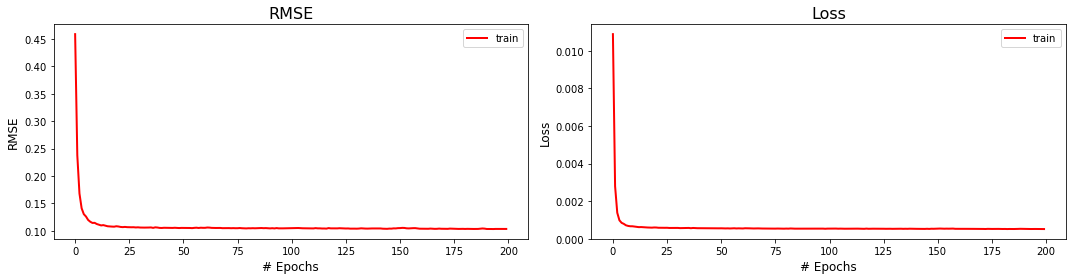

In [19]:
fig,axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(train_accuracy_history, 'r', lw=2, label='train')
# axs[0].plot(test_accuracy_history, 'k', lw=2, label='validation')
axs[0].set_title('RMSE', size=16)
axs[0].set_ylabel('RMSE', size=12)

axs[1].plot(train_loss_history, 'r', lw=2, label='train')
# axs[1].plot(test_loss_history, 'k', lw=2, label='validation')
axs[1].set_title('Loss', size=16)
axs[1].set_ylabel('Loss', size=12)


for ax in axs:
    ax.legend()
    ax.set_xlabel('# Epochs', size=12)
fig.tight_layout()

***

## Step five - apply trained model

In [20]:
d.shape

(198, 453)

In [21]:
# Make a new noisy realisation so it's different from the training set
testdata, _ = add_whitegaussian_noise(d[:196,:452], sc=0.1)

In [22]:
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()
test_prediction = network(torch_testdata.to(device))
test_pred = test_prediction.detach().cpu().numpy().squeeze()

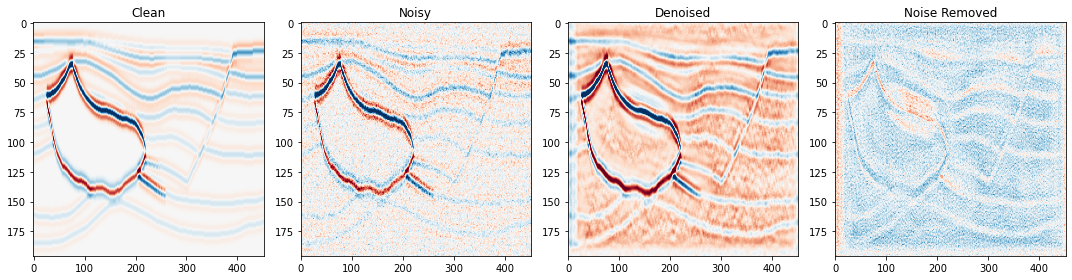

In [23]:
fig,axs = plt.subplots(1,4,figsize=[15,4])
axs[0].imshow(d[:196,:452], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(testdata, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[3].imshow(testdata-test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_title('Clean')
axs[1].set_title('Noisy')
axs[2].set_title('Denoised')
axs[3].set_title('Noise Removed')

fig.tight_layout()